In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('email-Eu-core')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 1005
Number of Edges: 51142
Density: 0.050684822897464864


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 101.77512437810945
Median Degree: 64.0


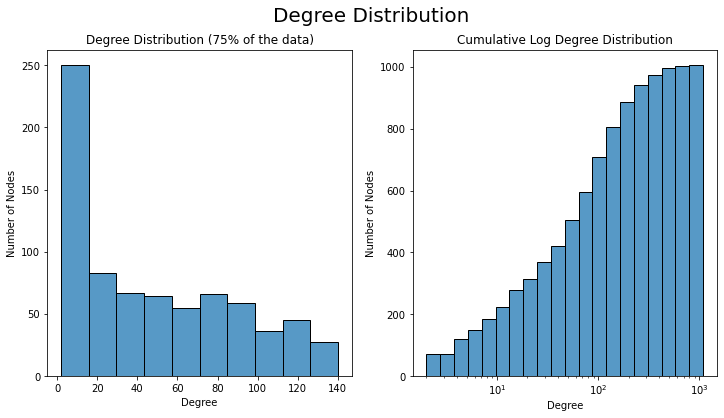

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,1092,160
1,758,121
2,746,107
3,738,62
4,712,86
5,696,82
6,616,434
7,604,183
8,560,5
9,550,129


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.459
Diameter: 7


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,986.000000,986.000000,986.000000,986.000000,891.000000
mean,0.034363,0.001014,0.020095,0.001014,0.450451
std,0.038004,0.003025,0.024719,0.000947,0.220047
min,0.001015,0.000000,0.000001,0.000174,0.000000
25%,0.007107,0.000000,0.003436,0.000349,0.309708
50%,0.024365,0.000000,0.011020,0.000745,0.402299
75%,0.046701,0.000293,0.026361,0.001331,0.552161
max,0.352284,0.041923,0.165846,0.009246,1.000000


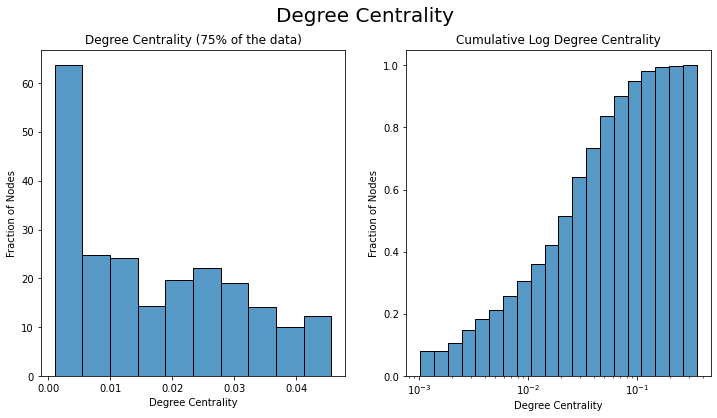

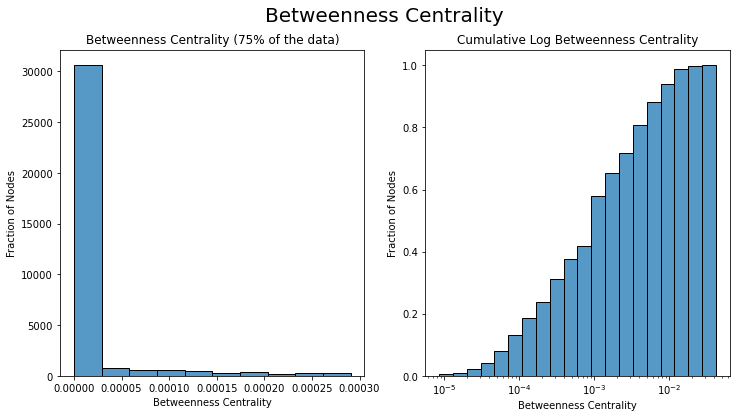

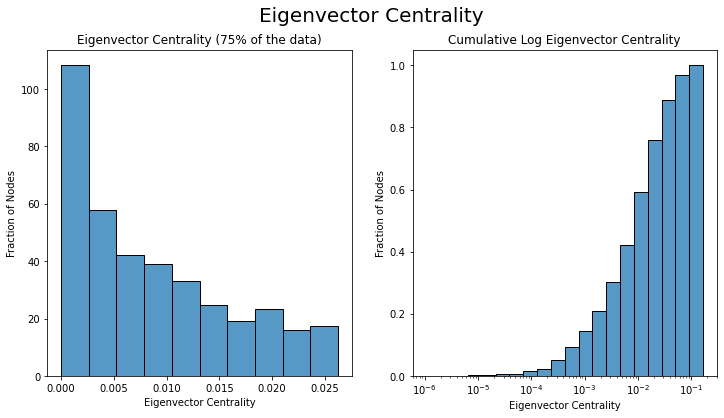

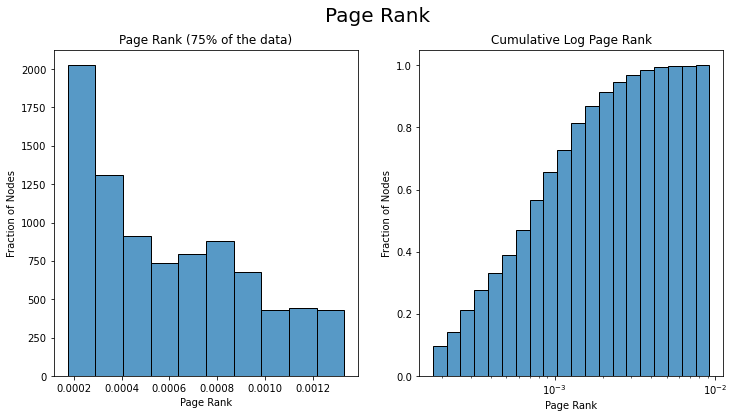

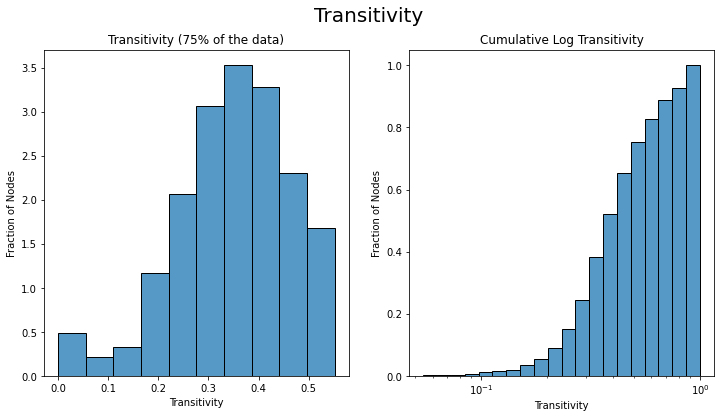

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.352284,160,0.041923,160,0.165846,160,0.009246,160,1.0,903
1,0.237563,121,0.020053,533,0.148421,121,0.006186,121,1.0,713
2,0.236548,82,0.019293,191,0.145252,82,0.006147,82,1.0,630
3,0.224365,107,0.018447,64,0.139876,107,0.005951,107,1.0,631
4,0.221320,86,0.017885,82,0.131498,62,0.005832,86,1.0,632
5,0.219289,62,0.017239,411,0.125305,434,0.005536,62,1.0,637
6,0.187817,434,0.016139,121,0.124382,249,0.005009,5,1.0,870
7,0.182741,13,0.015930,62,0.114020,183,0.004678,13,1.0,646
8,0.179695,166,0.015735,393,0.112217,86,0.004639,166,1.0,677
9,0.175635,183,0.015623,84,0.110335,166,0.004620,434,1.0,911


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 20
Size of the largest component: 986


Text(0.5, 1.0, 'Connected Components')

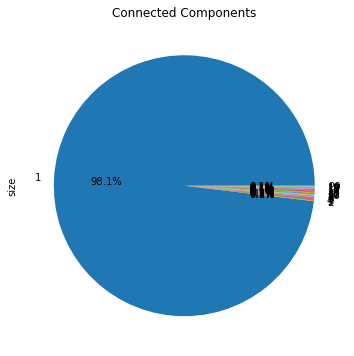

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
User,User,1005,101.775124,64.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

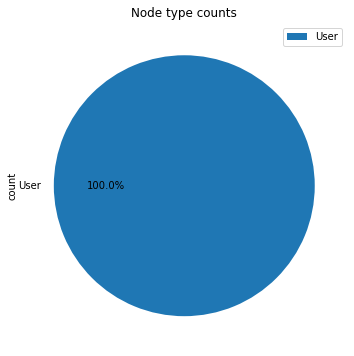

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

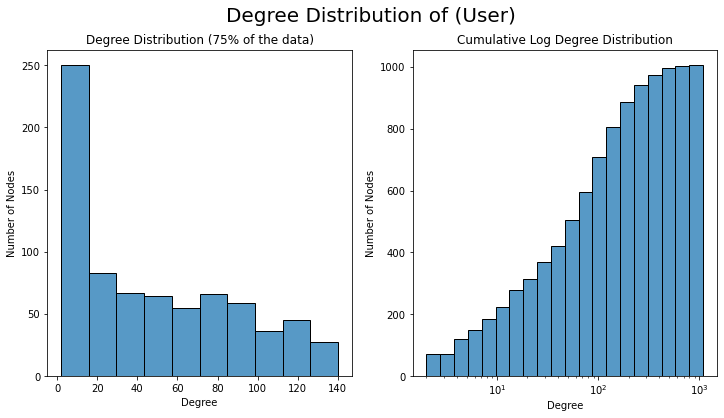

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,1092,160
1,758,121
2,746,107
3,738,62
4,712,86
5,696,82
6,616,434
7,604,183
8,560,5
9,550,129


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 1


,type,count
COMMUNITCATES,COMMUNITCATES,51142


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

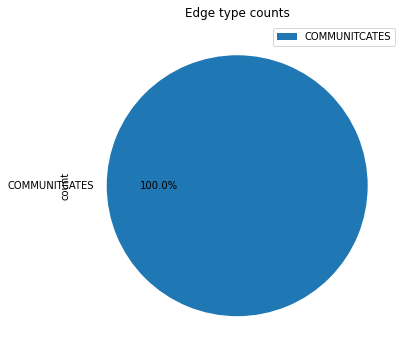

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for User


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.352284,160,0.041923,160,0.165846,160,0.009246,160,1.0,903
1,0.237563,121,0.020053,533,0.148421,121,0.006186,121,1.0,713
2,0.236548,82,0.019293,191,0.145252,82,0.006147,82,1.0,630
3,0.224365,107,0.018447,64,0.139876,107,0.005951,107,1.0,631
4,0.221320,86,0.017885,82,0.131498,62,0.005832,86,1.0,632
5,0.219289,62,0.017239,411,0.125305,434,0.005536,62,1.0,637
6,0.187817,434,0.016139,121,0.124382,249,0.005009,5,1.0,870
7,0.182741,13,0.015930,62,0.114020,183,0.004678,13,1.0,646
8,0.179695,166,0.015735,393,0.112217,86,0.004639,166,1.0,677
9,0.175635,183,0.015623,84,0.110335,166,0.004620,434,1.0,911


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.43103142457686
Number of communities: 8


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

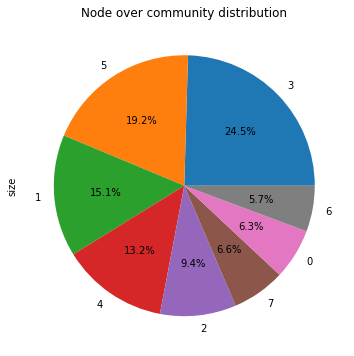

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.132995,301,0.007467,74,0.075842,17,0.003473,301,0.821429,905
1,0.112690,17,0.007366,560,0.065196,301,0.002821,17,0.722222,696
2,0.094416,74,0.005610,17,0.055564,215,0.002529,215,0.653846,341
3,0.093401,215,0.004696,218,0.051138,74,0.002490,74,0.625000,313
4,0.074112,459,0.004658,222,0.050773,226,0.002023,459,0.500000,629
5,0.073096,222,0.003930,221,0.047086,222,0.001936,222,0.500000,596
6,0.069036,218,0.003253,226,0.042608,221,0.001844,218,0.467836,297
7,0.063959,226,0.002897,223,0.041906,459,0.001785,560,0.457672,225
8,0.061929,221,0.002254,268,0.039366,223,0.001641,221,0.438406,317
9,0.058883,223,0.002045,311,0.038291,18,0.001638,226,0.423656,310


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.173604,5,0.017239,411,0.097658,211,0.005009,5,1.0,743
1,0.156345,211,0.010669,4,0.085952,63,0.004385,211,1.0,991
2,0.127919,58,0.010640,252,0.085738,58,0.003249,411,1.0,988
3,0.126904,63,0.009744,58,0.081599,303,0.003207,6,1.0,977
4,0.122843,252,0.008116,209,0.079464,5,0.003201,63,1.0,625
5,0.116751,6,0.006600,812,0.078273,252,0.003196,58,1.0,630
6,0.107614,411,0.005836,271,0.074371,210,0.003125,252,1.0,631
7,0.104569,303,0.005812,234,0.060844,137,0.002676,303,1.0,637
8,0.097462,4,0.005253,5,0.060522,4,0.002655,2,1.0,842
9,0.096447,2,0.004962,174,0.057793,285,0.002575,4,1.0,646


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.107614,44,0.012838,856,0.067551,365,0.003208,971,1.000000,893
1,0.098477,971,0.012444,441,0.066307,44,0.002861,44,0.761905,833
2,0.093401,365,0.003775,44,0.055183,362,0.002467,498,0.700000,967
3,0.087310,498,0.003715,971,0.043442,856,0.002363,365,0.696970,503
4,0.084264,141,0.001979,506,0.041940,19,0.002293,141,0.690058,573
5,0.077157,11,0.001868,12,0.037207,441,0.002104,11,0.672727,488
6,0.073096,7,0.001283,19,0.037120,141,0.002041,7,0.661905,500
7,0.073096,19,0.001222,498,0.036950,430,0.001927,19,0.649123,570
8,0.071066,362,0.001170,141,0.034976,506,0.001867,506,0.644444,957
9,0.069036,856,0.001159,452,0.031553,11,0.001826,856,0.625000,247


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.237563,121,0.020053,533,0.148421,121,0.006186,121,1.000000,989
1,0.236548,82,0.017885,82,0.145252,82,0.006147,82,1.000000,969
2,0.224365,107,0.016139,121,0.139876,107,0.005951,107,1.000000,968
3,0.219289,62,0.015930,62,0.131498,62,0.005536,62,1.000000,966
4,0.187817,434,0.015623,84,0.125305,434,0.004639,166,1.000000,911
5,0.179695,166,0.014281,107,0.124382,249,0.004620,434,1.000000,693
6,0.170558,249,0.014159,166,0.110335,166,0.004140,249,1.000000,702
7,0.159391,533,0.011064,420,0.109346,105,0.004123,533,1.000000,713
8,0.148223,105,0.010779,21,0.105418,87,0.003804,84,0.952381,432
9,0.144162,106,0.010753,434,0.102734,142,0.003733,21,0.933333,594


No node timestamp data available
Top 10 Nodes by Statistic for Community 4


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.182741,13,0.015243,333,0.105484,114,0.004678,13,1.0,997
1,0.144162,114,0.011546,115,0.098465,115,0.003569,114,1.0,978
2,0.137056,333,0.009994,340,0.095082,333,0.003542,333,1.0,766
3,0.132995,115,0.009145,170,0.092090,169,0.003414,96,1.0,436
4,0.121827,96,0.008295,28,0.085693,13,0.003264,115,1.0,878
5,0.120812,169,0.007958,494,0.083055,28,0.002984,165,1.0,891
6,0.120812,165,0.006669,318,0.078171,340,0.002948,494,1.0,895
7,0.117766,494,0.004955,35,0.077618,165,0.002904,169,1.0,439
8,0.109645,133,0.004424,464,0.072247,367,0.002889,340,1.0,983
9,0.108629,340,0.003499,427,0.071963,494,0.002779,133,0.9,721


No node timestamp data available
Top 10 Nodes by Statistic for Community 5


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.352284,160,0.041923,160,0.165846,160,0.009246,160,1.0,821
1,0.221320,86,0.019293,191,0.114020,183,0.005832,86,1.0,456
2,0.175635,183,0.018447,64,0.112217,86,0.004492,64,1.0,873
3,0.172589,64,0.015291,129,0.108917,129,0.004318,183,1.0,874
4,0.166497,129,0.015231,65,0.105355,128,0.004276,129,1.0,882
5,0.148223,128,0.014538,820,0.089935,64,0.003695,128,1.0,903
6,0.131980,820,0.011875,183,0.088837,820,0.003416,820,1.0,348
7,0.123858,280,0.011827,280,0.085528,280,0.003133,280,1.0,620
8,0.093401,172,0.009305,290,0.067190,41,0.002912,65,1.0,801
9,0.092386,232,0.008792,401,0.063025,290,0.002556,232,1.0,724


No node timestamp data available


### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.00011983761784615982
Number of communities: 2


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

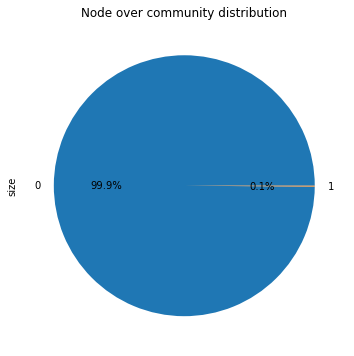

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.352284,160,0.041923,160,0.165846,160,0.009246,160,1.0,903
1,0.237563,121,0.020053,533,0.148421,121,0.006186,121,1.0,713
2,0.236548,82,0.019293,191,0.145252,82,0.006147,82,1.0,630
3,0.224365,107,0.018447,64,0.139876,107,0.005951,107,1.0,631
4,0.221320,86,0.017885,82,0.131498,62,0.005832,86,1.0,632
5,0.219289,62,0.017239,411,0.125305,434,0.005536,62,1.0,637
6,0.187817,434,0.016139,121,0.124382,249,0.005009,5,1.0,870
7,0.182741,13,0.015930,62,0.114020,183,0.004678,13,1.0,646
8,0.179695,166,0.015735,393,0.112217,86,0.004639,166,1.0,677
9,0.175635,183,0.015623,84,0.110335,166,0.004620,434,1.0,911


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.003046,788,0.0,788,0.000094,788,0.000347,788,NaN,788


No timestamp data available
